# Tweemotion

### Info 154
### Yoon Sung Hong, Karam Mukhtar

# Twitter Auto-Data Scraping

In [ ]:
import tweepy
import pandas as pd

### Upload a file with the keys from Twitter saved in them 

In [ ]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled
# in in question 1):
with open(key_file) as f:
    keys = json.load(f)
# if you print or view the contents of keys be sure to delete the cell!

import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth, wait_on_rate_limit=True)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

In [ ]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    import json
    with open(path) as f:
        return json.load(f)

def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Status objects, each representing one tweet."""
    import tweepy

    # Authenticating:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth, wait_on_rate_limit=True)

    # Getting as many recent tweets as Twitter will let us have for the account:
    return list(tweepy.Cursor(api.user_timeline, id=user_account_name,tweet_mode='extended').items())


def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Status) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
# Saving the tweets to a file as "pickled" objects:
    with open(path, "wb") as f:    
        import pickle
        pickle.dump(tweets, f)
        return
    
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Status objects, each representing one tweet."""
    # Re-loading the results:
    with open(path, "rb") as f:
        import pickle
        return pickle.load(f)
    

def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    from pathlib import Path
    
    tweets_save_path = "{0}_recent_tweets.pkl".format(user_account_name)
    if Path(tweets_save_path).is_file():
        return load_tweets(tweets_save_path)
        
    else:
        curr_keys = load_keys(keys_path)
        recent_tweets = download_recent_tweets_by_user(user_account_name, curr_keys)
        save_tweets(recent_tweets, tweets_save_path)
        return load_tweets(tweets_save_path)

### Pulling the list of twitter usernames using api

#### Republican senators + governors

In [ ]:
rep_gov_sen = []
for member in tweepy.Cursor(api.list_members, 'The_RGA', 'gop-governors').items():
    rep_gov_sen.append(member.screen_name)
for member in tweepy.Cursor(api.list_members, 'SenateGOP', 'senaterepublicans').items():
    rep_gov_sen.append(member.screen_name)

#### Republican house

In [ ]:
rep_house = []
for member in tweepy.Cursor(api.list_members, 'housegop', 'house-republicans').items():
    rep_house.append(member.screen_name)

#### Democrat senators + governors

In [ ]:
dem_gov_sen = []
for member in tweepy.Cursor(api.list_members, 'TheDemocrats', 'democratic-governors').items():
    dem_gov_sen.append(member.screen_name)
for member in tweepy.Cursor(api.list_members, 'TheDemocrats', 'senate-democrats').items():
    dem_gov_sen.append(member.screen_name)

#### Democrat house

In [ ]:
dem_house = []
for member in tweepy.Cursor(api.list_members, 'TheDemocrats', 'house-democrats').items():
    dem_house.append(member.screen_name)

### Data collection using api

Example code demonstrated below only shows the collection from republican senators and governors. Note that we applied it to all four of the lists above for data collection in practice.

In [ ]:
tweet_list = []
for user in rep_gov_sen:
    curr_tweets = get_tweets_with_cache(user, key_file)
    print("Number of tweets downloaded:", len(curr_tweets))   
    tweet_list += curr_tweets    

In [ ]:
ids = []
times = []
sources = []
texts = []
favorite_count = []
retweet_counts = []
user = []

for tweet in tweet_list:
    ids.append(tweet.id_str)
    times.append(tweet.created_at)
    sources.append(tweet.source)
    texts.append(tweet.full_text)
    retweet_counts.append(tweet.retweet_count)
    favorite_count.append(tweet.favorite_count)
    user.append(tweet.user)
    
formatted_tweets = pd.DataFrame(
    data={'id': ids,
          'time': times,
          'source': sources,
          'text': texts,
          'retweet_count': retweet_counts,
          'favorite_count' : favorite_count,
          'user' : user
          })
formatted_tweets = formatted_tweets.set_index("id")

In [ ]:
def splitting(x):
    befor_keyowrd, keyword, after_keyword = str(x).partition("'screen_name': ")
    return after_keyword

In [ ]:
formatted_tweets["user"] = formatted_tweets["user"].apply(lambda x: splitting(x).split(",")[0].replace("'", ''))

In [ ]:
formatted_tweets.to_csv("GOP_gov_senator.csv")

# Data Cleaning and Preprocessing

The actual cleaning was done on all data, but for this demonstration, we will show it only in context of one part of our dataset, the democrat governors and senators.  

This is because the latter portion of this (the RNN modeling) required AWS computing and was done on a separate notebook. Our preprocessing steps were done and prepared separately on our own laptops; we saved the preprocessed data as a csv and imported it directly to the AWS to be used for RNN.

In [49]:
!python3 -m pip install lxml

In [43]:
import lxml

In [50]:
#imports
import pandas as pd
import pandas as pd
import re
import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
import warnings
warnings.filterwarnings('ignore')
import re
import lxml
from bs4 import BeautifulSoup

In [36]:
tweets = pd.read_csv('dem_gov_sen.csv')

In [ ]:
tweets = tweets[tweets.text.isnull() == False]

In [38]:
tweets.head()

,id,time,source,text,retweet_count,favorite_count,user
0,1115311440989184000,2019-04-08 17:52:23,TweetDeck,"Get well soon, Assemblyman. @SeanMRyan149 http...",2.0,12.0,NYGovCuomo
1,1115298202092298241,2019-04-08 16:59:47,Twitter Web Client,This report is deeply alarming and goes agains...,39.0,133.0,NYGovCuomo
2,1114890416913092608,2019-04-07 13:59:23,TweetDeck,One of the big wins in the budget was the pass...,29.0,96.0,NYGovCuomo
3,1114667816941162497,2019-04-06 23:14:51,Twitter Web Client,We have to act quickly to fight climate change...,75.0,169.0,NYGovCuomo
4,1114546662112923648,2019-04-06 15:13:26,Twitter Media Studio,New York just make some important changes to o...,40.0,129.0,NYGovCuomo


In [59]:
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

The code ran successfully on our laptops, but failed to run on AWS since it is not a MAC OSX environment. If you want to see the results after the whole preprocessing steps, you can find it in df.head() portion in the **filtered_w_stop_text** and **filtered_text** columns in the Sentence Embeddings section.

In [ ]:
testing = tweets["text"]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result

In [ ]:
stopWords = set(stopwords.words('english'))
stopWords = list(stopWords)
stopWords.append('rt')

def clean_tweet(tweet):
    spaced = re.split('\W+', tweet)
    cleaned = [i for i in spaced if i not in stops_to_remove]
    return cleaned

In [ ]:
preprocessed_tweets = pd.DataFrame({"nltk":test_result}) 
tweets["filtered_text"] = preprocessed_tweets["nltk"].apply(lambda x: clean_tweet(x))

In [ ]:
tweets["filtered_w_stop_text"] = preprocessed_tweets.nltk.apply(lambda x: re.split('\W+', x))

# Sentence Embeddings generation using InferSent (Bi-Directional RNN)

Infersent is a method using bi-directional LSTM to get sentence embeddings. We apply this on our preprocessed tweet data to get a 4096-dimensional representation of each tweet.

For this part, you actually need to clone the InferSent repository made by facebook. The repo git link is the following:  
https://github.com/facebookresearch/InferSent.git

Our code was run in the directory of Infersent/Encoder. 

In [1]:
!pip install torch

In [2]:
# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint

import numpy as np
import torch

In [ ]:
!curl -Lo infersent1.pkl https://dl.fbaipublicfiles.com/senteval/infersent/infersent1.pkl

In [ ]:
!mkdir ../dataset/GloVe

In [ ]:
!curl -Lo ../dataset/GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip ../dataset/GloVe/glove.840B.300d.zip

## Load model

In [3]:
# Load model
from models import InferSent
model_version = 1
MODEL_PATH = "../encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [4]:
# Keep it on CPU or put it on GPU
use_cuda = True
model = model.cuda() if use_cuda else model

In [5]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'glove.840B.300d.txt' if model_version == 1 else '../dataset/fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [6]:
import pandas as pd
import ast
df = pd.read_csv('tokenized_tweets.csv')

In [7]:
df.head()

,Unnamed: 0,id,favorite_count,retweet_count,text,time,user,party,filtered_w_stop_text,filtered_text
0,0,1115311440989184000,12.0,2.0,"Get well soon, Assemblyman. @SeanMRyan149 http...",2019-04-08 17:52:23,NYGovCuomo,1,"['get', 'well', 'soon', 'assemblyman']","['get', 'well', 'soon', 'assemblyman']"
1,1,1115298202092298241,133.0,39.0,This report is deeply alarming and goes agains...,2019-04-08 16:59:47,NYGovCuomo,1,"['this', 'report', 'is', 'deeply', 'alarming',...","['report', 'deeply', 'alarming', 'goes', 'ever..."
2,2,1114890416913092608,96.0,29.0,One of the big wins in the budget was the pass...,2019-04-07 13:59:23,NYGovCuomo,1,"['one', 'of', 'the', 'big', 'wins', 'in', 'the...","['one', 'big', 'wins', 'budget', 'passage', 's..."
3,3,1114667816941162497,169.0,75.0,We have to act quickly to fight climate change...,2019-04-06 23:14:51,NYGovCuomo,1,"['we', 'have', 'to', 'act', 'quickly', 'to', '...","['act', 'quickly', 'fight', 'climate', 'change..."
4,4,1114546662112923648,129.0,40.0,New York just make some important changes to o...,2019-04-06 15:13:26,NYGovCuomo,1,"['new', 'york', 'just', 'make', 'some', 'impor...","['new', 'york', 'make', 'important', 'changes'..."


In [8]:
df['text_full'] = df["filtered_text"].apply(lambda x: " ".join(ast.literal_eval(x)))

In [9]:
!pip install nltk

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# Load embeddings of K most frequent words
#model.build_vocab_k_words(K=100000)
#once we have the sentences ready
model.build_vocab(df['text_full'])

Found 82098(/179459) words with w2v vectors
Vocab size : 82098


## Encode sentences

In [12]:
# gpu mode : >> 1000 sentences/s
# cpu mode : ~100 sentences/s

In [13]:
embeddings = model.encode(df['text_full'], verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 17116920/17746241 (96.5%)
Speed : 1167.6 sentences/s (gpu mode, bsize=64)
nb sentences encoded : 1261746


# Visualization

In [14]:
!pip install sklearn
!pip install matplotlib

In [15]:
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.manifold import TSNE

In [16]:
embeddings.shape

(1261746, 4096)

Since we have over 1 million pieces of data in 4096 dimensions, it will take extremely long to use dimensionality reduction technique on the whole data. Therefore, we will sample a proportion of the data and run T-SNE on this data. The visualization is only for the purpose of showing that the language used in the tweet directly contributes to the reaction you get on the internet (likes, retweets), so a small sample should be sufficient to show this.

In [18]:
# select a random sample without replacement
from random import seed
from random import sample

# seed random number generator
seed(1)
# prepare a sequence
sequence = [i for i in range(1261746)]
print(sequence)
# select a subset without replacement
subset = sample(sequence, 1000)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
favorites = np.array(df.favorite_count)
retweets = np.array(df.retweet_count)

Let's look at one particular politician's twitter account.

In [123]:
bernie = embeddings[df.user == 'SenSanders']
bernie_fav = favorites[df.user == 'SenSanders']
bernie_ret = retweets[df.user == 'SenSanders']

In [124]:
#running TSNE to reduce dimensions to 2
arr_embedded = TSNE(n_components=2).fit_transform(bernie)

In [125]:
arr_embedded.shape

(3217, 2)

In [129]:
#normalizing favorites and retweets
fav_norm = (bernie_fav - np.min(bernie_fav))/(np.max(bernie_fav) - np.min(bernie_fav))
ret_norm = (bernie_ret - np.min(bernie_ret))/(np.max(bernie_ret) - np.min(bernie_ret))

In [147]:
ret_ls = []
dat_ls = []
for i in range(len(ret_norm)):
    if ret_norm[i] > 0.05:
        ret_ls.append(ret_norm[i])
        dat_ls.append(arr_embedded[i])
dat_ls = np.array(dat_ls)

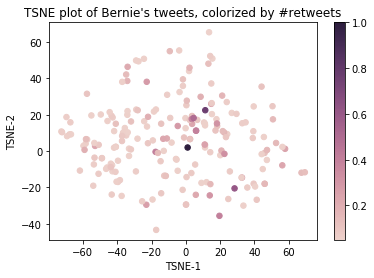

In [149]:
from matplotlib import pyplot as plt
import seaborn as sns

cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(dat_ls[:,0], dat_ls[:,1], c=ret_ls, s=30, cmap=cmap)
f.colorbar(points)
plt.title("TSNE plot of Bernie's tweets, colorized by #retweets")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()

In [150]:
fav_ls = []
dat_ls = []
for i in range(len(fav_norm)):
    if fav_norm[i] > 0.05:
        fav_ls.append(fav_norm[i])
        dat_ls.append(arr_embedded[i])
dat_ls = np.array(dat_ls)

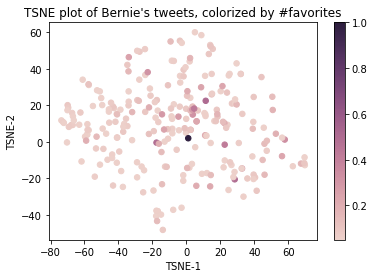

In [152]:
from matplotlib import pyplot as plt
import seaborn as sns

cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(dat_ls[:,0], dat_ls[:,1], c=fav_ls, s=30, cmap=cmap)
f.colorbar(points)
plt.title("TSNE plot of Bernie's tweets, colorized by #favorites")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()

# MLP

In [ ]:
!pip install d2l
!pip install sklearn

In [ ]:
import mxnet as mx
ctx = mx.gpu()

In [ ]:
df['party'][df['party'] == -1] = 0

In [ ]:
import sys
sys.path.insert(0, '..')

import d2l
from mxnet import gluon, init
from mxnet.gluon import loss as gloss, nn
from sklearn.model_selection import train_test_split
from mxnet import gluon, init, nd, autograd
import time

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['party'], test_size=0.2, random_state=42)

In [ ]:
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs, lr_period):
    """Train and evaluate a model."""
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        if epoch > 0 and epoch % lr_period == 0:
             trainer.set_learning_rate(trainer.learning_rate * .85)
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                  for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
                 time.time() - start))


In [ ]:
def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n = nd.array([0]), 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar() / n

In [ ]:
net = nn.HybridSequential()
net.add(nn.Dense(2048, activation='relu'))
net.add(gluon.nn.Dropout(0.25))
net.add(nn.Dense(512, activation='relu'))
net.add(nn.Dense(2))
#     net.initialize(init.Normal(sigma=0.01))
net.initialize(init.Xavier(), ctx=ctx)
net.hybridize()

# net.initialize(init.Normal(sigma=0.01))

batch_size = 128
train_set = gdata.ArrayDataset(X_train, nd.array(y_train))
test_set = gdata.ArrayDataset(X_test, nd.array(y_test))
train_iter = gdata.DataLoader(train_set, batch_size, shuffle=True)
test_iter = gdata.DataLoader(test_set, batch_size)

loss = gloss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.2, 'wd': 0.001})
num_epochs = 150
# d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None,
#               None, trainer)

In [ ]:
train(train_iter, test_iter, net, gloss.SoftmaxCrossEntropyLoss(), trainer, ctx, num_epochs, 4)